In [1]:
%load_ext autoreload
%autoreload 2
%reset -f
from custom_imports import *

In [2]:
client = Client(scheduler_file="/home/bzr0014/schedfile")

In [3]:
client.restart()

Client Scheduler: tcp://131.204.27.88:8786 Dashboard: http://131.204.27.88:8787/status,Cluster Workers: 50 Cores: 100 Memory: 1000.00 GB


In [4]:
DATAROOT = "data"

In [5]:
multi_class_images = {k: v for k, v in joblib.load(f"{DATAROOT}/multi_label_images.dict").items()}
image_names = joblib.load(f"{DATAROOT}/image_names.pkl")
raw_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/raw_images.pkl"))).items()}
original_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/images.pkl"))).items()}

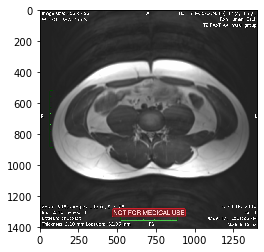

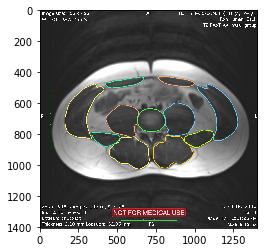

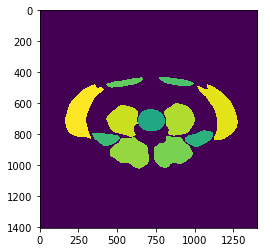

In [6]:
label = np.random.choice(list(multi_class_images.keys()))
plt.imshow(raw_images[label])
plt.show()
plt.imshow(original_images[label])
plt.show()
plt.imshow(multi_class_images[label])

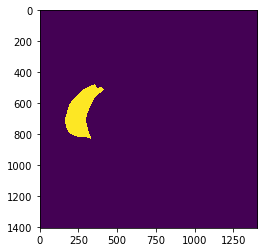

In [7]:
x = multi_class_images[label] == 250
plt.imshow(x)

In [8]:
import tensorflow as tf
layer_1_filter_size = 3
layer_1_filter_num = 20
layer_1_stride = 1
layer_2_filter_size = 5
layer_2_filter_num = 20
layer_2_stride = 1
layer_3_filter_num = 20
layer_3_filter_size = 7
layer_3_stride = 1
layer_3_dropout_rate = .25

n_fc1 = 128
fc1_dropout_rate = .5
neighSize = 41

n_outputs = 12
output_shape = layer_3_filter_num * \
    (neighSize-layer_1_filter_size-layer_2_filter_size-layer_3_filter_size+3)**2

tf.reset_default_graph()

print("output shape:", output_shape)

with tf.name_scope('inputs'):
    X_tf = tf.placeholder(tf.float32, [None, neighSize, neighSize, 1])
    y_tf = tf.placeholder(tf.int64, [None])
    punishment1 = tf.ones_like(y_tf)
    punishment2 = tf.ones_like(y_tf) * 10
    punishment = tf.cast(tf.where(y_tf == 0, punishment1, punishment2), tf.float32)
    training = tf.placeholder_with_default(False, shape=[], name='training')    
    
with tf.name_scope('convs'):
    conv1 = tf.layers.conv2d(X_tf, filters=layer_1_filter_num, kernel_size=layer_1_filter_size,\
                             strides=layer_1_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv1')
    conv2 = tf.layers.conv2d(X_tf, filters=layer_2_filter_num, kernel_size=layer_2_filter_size,\
                             strides=layer_2_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv2')
    conv3 = tf.layers.conv2d(X_tf, filters=layer_3_filter_num, kernel_size=layer_3_filter_size,\
                             strides=layer_3_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv3')   
with tf.name_scope('skip'):
    #skip = conv3 + X_tf
    skip = tf.concat([conv3, X_tf], axis=3)
    print(skip)
    skip_drop = tf.layers.dropout(skip, rate=layer_3_dropout_rate, training=training)
    skip_flat = tf.reshape(skip_drop, shape=[-1, neighSize*neighSize*(layer_3_filter_num+1)])

with tf.name_scope('fc1'):
    fc1 = tf.layers.dense(skip_flat, n_fc1, activation=tf.nn.relu, name='fc1')
    fc1_drop = tf.layers.dropout(fc1, rate=fc1_dropout_rate, training=training)

with tf.name_scope('output'):
    logits = tf.layers.dense(fc1_drop, n_outputs, name='output')
    y_prob = tf.nn.softmax(logits, name='y_prob')

with tf.name_scope('training'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_tf)
    loss = tf.reduce_mean(xentropy)# * punishment)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y_tf, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope('init_and_save'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

output shape: 16820
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Tensor("skip/concat:0", shape=(?, 41, 41, 21), dtype=float32)
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.Dense instead.


In [7]:
import numpy as np
n_epochs = 1000
batch_size = 100
train_indicies = np.arange(X.shape[0])
model_name = './best'

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 30
best_model_params = None 

with tf.Session() as sess:
    load_model(model_name)
    for epoch in range(n_epochs):
        np.random.shuffle(train_indicies)
        acc_trains = []
        for iteration in range(int(math.ceil(X.shape[0]/batch_size))):
            start_idx = (iteration*batch_size)%X.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            X_batch = X[idx, :]
            y_batch = Y[idx]
            _, batch_acc = sess.run([training_op, accuracy], feed_dict={X_tf: X_batch, y_tf: y_batch, training: True})
            acc_trains.append(batch_acc)

        
        #acc_train = accuracy.eval(feed_dict={X_tf: X[train_indicies[:1000]], y_tf: y_train[train_indicies[:1000]]})
        acc_train = np.mean(acc_trains)
        
        acc_tests = []
        losses = []
        for iteration in range(int(math.ceil(X_val.shape[0]/batch_size))):
            start_idx = (iteration * batch_size) % X_val.shape[0]
            batch_acc, batch_loss = sess.run([accuracy, loss], \
                                             feed_dict={X_tf: X_val[start_idx:start_idx+batch_size],
                                                        y_tf: y_val[start_idx:start_idx+batch_size]})
            acc_tests.append(batch_acc)
            losses.append(batch_loss)
            
            
        acc_val = np.mean(acc_tests) 
        loss_val = np.mean(losses)
        
        if loss_val < best_loss_val:
            best_loss_val = loss_val
            check_since_last_progress = 0
            best_model_params = get_model_params()
        else:
            checks_since_last_progress += 1       
        print("%03d Train accuracy: %6.4f | Validation accuracy: %6.4f | loss: %5.3f"%(epoch, acc_train, acc_val, loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break
        save_path = saver.save(sess, model_name)
        
    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X_tf: X, y_tf: y_train})
    print("Final accuracy on test set:", acc_test)
    save_path = saver.save(sess, model_name)

NameError: name 'X' is not defined